In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from tabulate import tabulate
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.optimize import curve_fit
import itertools
import random

# Inputs: adjust path and file_name

In [3]:
path = ''           #enter path
file_name = ''      #enter file_name of .cs file

cs = np.load(path+file_name)

FileNotFoundError: [Errno 2] No such file or directory: ''

In [35]:
def gauss(x, *p):
    A, mu, sigma, y0 = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))+y0

def quadratic(x, *p):
    A, mu, y0 = p
    return A*(x-mu)**2+y0
    


def show_1d_energy(cs = cs, mode=0, setminimumtozero = True,
                   energy_percentile_cut = 0.1, energy_gauss_percentile_cut = 3.0 , 
                   p0 = [-3, 0, 100,9], p0_quadratic = [0.001, 0,0], energy_fit = "quadratic",  
                   show_legend = True, x_tick_spacing = 200, x_filter_tick_spacing = 200,
                   color_data = "black", marker_data = 'x', marker_size = 100, linewidth_data=2, 
                   color_kde = "#1C6E8C", linewidth_kde = 6, 
                   color_gauss = "#F28F3B", linewidth_gauss = 8, linestyle_gauss = '-',
                   xylabelsize = 18, xyticklabelsize = 16, lablesize = 20,
                   saveaspdf = 0, output_path = path):
    data = cs['components_mode_{}/value'.format(mode)]
    hist, bin_edges = np.histogram(data, bins = 'scott', density=True)    #histogram of data, output |d|d|d|d| with d=datapoint, |=edge (Zaunproblem) 
    hist_binwidth = bin_edges[1]-bin_edges[1]                            #calculate bin_width
    hist_range = bin_edges[:-1] + hist_binwidth/2                        #centres of bin_edges
    kde = gaussian_kde(dataset = data, bw_method ='scott')    #kernel density fit of data
    gauss_hist_coeff, gauss_hist_var_matrix = curve_fit(f=gauss, xdata=hist_range, ydata=hist ,p0=p0)
    
    
    
    #extract x_values above and below threshold and corresponding y_values from histogram (bandpass) for the energy plot
    energy_lower_limit = np.percentile(data, energy_percentile_cut)
    energy_upper_limit = np.percentile(data, 100-energy_percentile_cut)
    hist_range_highpass = hist_range[np.where(hist_range > energy_lower_limit)]
    hist_highpass = hist[np.where(hist_range > energy_lower_limit)]
    hist_range_bandpass = hist_range_highpass[np.where(hist_range_highpass < energy_upper_limit)]
    hist_bandpass = hist_highpass[np.where(hist_range_highpass < energy_upper_limit)]
    
    #extract x_values above and below threshold and corresponding y_values from histogram (bandpass) for the energy gauss fit
    energy_gauss_lower_limit = np.percentile(data, energy_gauss_percentile_cut)
    energy_gauss_upper_limit = np.percentile(data, 100-energy_gauss_percentile_cut)
    hist_range_gauss_highpass = hist_range[np.where(hist_range > energy_gauss_lower_limit)]
    hist_gauss_highpass = hist[np.where(hist_range > energy_gauss_lower_limit)]
    hist_range_gauss_bandpass = hist_range_gauss_highpass[np.where(hist_range_gauss_highpass < energy_gauss_upper_limit)]
    hist_gauss_bandpass = hist_gauss_highpass[np.where(hist_range_gauss_highpass < energy_gauss_upper_limit)]
    
    

    #calculate energies
    energy_hist_bandpass = - np.log(hist_bandpass)
    energy_kde_bandpass = - np.log(kde(hist_range_bandpass))
    
    #gauss fit of energy filtered data
    gauss_energy_hist_coeff, gauss_energy_hist_varmatrix = curve_fit(f=gauss, xdata=hist_range_gauss_bandpass, ydata=- np.log(hist_gauss_bandpass),p0=p0)     
    gauss_fit_energs_hist = gauss(hist_range_gauss_bandpass, *gauss_energy_hist_coeff)
    quadratic_energy_hist_coeff, quadratic_energy_hist_varmatrix = curve_fit(f=quadratic, xdata=hist_range_gauss_bandpass, ydata=- np.log(hist_gauss_bandpass),p0=p0_quadratic)     
    quadratic_fit_energs_hist = quadratic(hist_range_gauss_bandpass, *quadratic_energy_hist_coeff)
    
    #shift energy if desired: minimum of kde to zero
    min_energy = min(energy_kde_bandpass)
    if setminimumtozero: 
        energy_hist_bandpass -= min_energy
        energy_kde_bandpass -= min_energy
        gauss_fit_energs_hist -= min_energy
        quadratic_fit_energs_hist -= min_energy
    
    
    fig,axes = plt.subplots(1,2, figsize=(15, 7))
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    fig.suptitle("Mode {}".format(mode+1), fontsize=30, y=1.1)

    #axes[0].plot(hist_range_bandpass, hist_bandpass, marker = 'x', linestyle='')
    axes[0].scatter(hist_range, hist, marker = marker_data, s=marker_size, linewidth = linewidth_data, color = color_data, label="data_hist" )
    axes[0].plot(hist_range, kde(hist_range), label="kde",color=color_kde, linewidth=linewidth_kde,)
    axes[0].plot(hist_range, gauss(hist_range, *gauss_hist_coeff) ,label="fit_gauss", lw=linewidth_gauss, color = color_gauss, linestyle=linestyle_gauss)

    axes[0].set_xlabel("amplitude along component {}".format(mode+1),fontsize=xylabelsize)
    axes[0].set_ylabel("probability density",fontsize=xylabelsize)
    if show_legend:
        axes[0].legend(loc="upper right")
    axes[0].set_title("probability density\n")
    axes[0].xaxis.set_major_locator(ticker.MultipleLocator(x_filter_tick_spacing))   
    axes[0].set_ylim((0,0.005))
    axes[0].set_xlim((-600,600))
    axes[0].tick_params(axis='x', labelsize=xyticklabelsize)
    axes[0].tick_params(axis='y', labelsize=xyticklabelsize)
    axes[0].tick_params(direction='out', length=6, width=2,)
    axes[0].spines["bottom"].set_linewidth(2)
    axes[0].spines["top"].set_linewidth(2)
    axes[0].spines["left"].set_linewidth(2)
    axes[0].spines["right"].set_linewidth(2)


    axes[1].scatter(hist_range_bandpass, energy_hist_bandpass, marker = marker_data, s=marker_size, linewidth = linewidth_data, label="-ln(data_hist)", color = color_data)
    axes[1].plot(hist_range_bandpass, energy_kde_bandpass, label="-ln(kde)",lw=linewidth_kde, color = color_kde)   

    if energy_fit == 'gauss':
        axes[1].plot(hist_range_gauss_bandpass, gauss_fit_energs_hist ,label="fit_gauss", lw=linewidth_gauss, color = color_gauss, linestyle='-')
    elif energy_fit == 'quadratic':
        axes[1].plot(hist_range_gauss_bandpass, quadratic_fit_energs_hist ,label="fit_quadratic", lw=linewidth_gauss, color = color_gauss, linestyle='-')
    else:
        print("Use fit type 'quadratic' or 'gauss'")


    axes[1].set_xlabel("amplitude along component {}".format(mode+1),fontsize=xylabelsize)
    axes[1].set_ylabel(u"free energy ΔG [kT]",fontsize=xylabelsize)
    axes[1].xaxis.set_major_locator(ticker.MultipleLocator(x_tick_spacing))
    axes[1].set_ylim((-0.5,10))
    axes[1].set_xlim((-600,600))
    axes[1].tick_params(axis='x', labelsize=xyticklabelsize)
    axes[1].tick_params(axis='y', labelsize=xyticklabelsize)
    axes[1].tick_params(direction='out', length=6, width=2,)
    axes[1].spines["bottom"].set_linewidth(2)
    axes[1].spines["top"].set_linewidth(2)
    axes[1].spines["left"].set_linewidth(2)
    axes[1].spines["right"].set_linewidth(2)

    if show_legend:
        axes[1].legend(loc="lower right")
    axes[1].set_title("energy landscape\n",)
    
    if saveaspdf:
        plt.savefig(output_path + '/1D_energy_mode_{}_energypercentile{}_gausspercentile{}_{}-fit.pdf'.format(mode,energy_percentile_cut,energy_gauss_percentile_cut,energy_fit))

    
    

def show_2d_energy(cs = cs, modes = (0,1,2), energy_percentile_cut = 1, setminimumtozero = False,
                   x_tick_spacing = 200, x_filter_tick_spacing = 100,
                   xylabelsize = 18, xyticklabelsize = 16, lablesize = 20,
                   saveaspdf = False, output_path = path):
    fig,axes = plt.subplots(3,2, figsize=(15,20))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)

    combinations = itertools.combinations(modes, 2)
    for i, combination in enumerate(combinations):
        x = cs['components_mode_{}/value'.format(combination[0])]
        y = cs['components_mode_{}/value'.format(combination[1])]
        img = axes[i, 0].plot(x, y, marker = '.', markersize=1, linestyle='')
        axes[i, 0].set_xlabel("amplitude along component {}".format(combination[0]), fontsize=xyticklabelsize)
        axes[i, 0].set_ylabel("amplitude along component {}".format(combination[1]), fontsize=xyticklabelsize)
        axes[i, 0].set_title("components {} and {}".format(combination[0]+1, combination[1]+1), fontsize=xyticklabelsize)
        axes[i, 0].set_xlim(x.min(), x.max())
        axes[i, 0].set_ylim(y.min(), y.max())
        axes[i, 0].xaxis.set_major_locator(ticker.MultipleLocator(x_tick_spacing))
        axes[i, 0].yaxis.set_major_locator(ticker.MultipleLocator(x_tick_spacing))
        axes[i, 0].set(adjustable='box', aspect='auto')
        axes[i, 0].tick_params(axis='x', labelsize=xyticklabelsize)
        axes[i, 0].tick_params(axis='y', labelsize=xyticklabelsize)
        axes[i, 0].tick_params(direction='out', length=6, width=2,)
        axes[i, 0].spines["bottom"].set_linewidth(2)
        axes[i, 0].spines["top"].set_linewidth(2)
        axes[i, 0].spines["left"].set_linewidth(2)
        axes[i, 0].spines["right"].set_linewidth(2)
        
        x_lower_limit = np.percentile(x, energy_percentile_cut)
        x_upper_limit = np.percentile(x, 100-energy_percentile_cut)
        y_lower_limit = np.percentile(y, energy_percentile_cut)
        y_upper_limit = np.percentile(y, 100-energy_percentile_cut)
        
        x_filter = np.array([a for a in x if a >= x_lower_limit and a <= x_upper_limit])
        y_filter = np.array([a for a in y if a >= y_lower_limit and a <= y_upper_limit])
        
        xmin = x_filter.min()
        xmax = x_filter.max()
        ymin = y_filter.min()
        ymax = y_filter.max()
        
        xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]     ##create x and y mesh from mins to maxs with number of positions defined by number before the "j" -> e.g. two 100x100 arrays
        xx_flat =  xx.ravel()                                 #flatten arrays -> 100,000x1 array
        yy_flat = yy.ravel()
        positions = np.vstack([xx_flat, yy_flat])             #2x100,000array with all possible (x,y) positions
        values = np.vstack([x_filter, y_filter])
        
        kde = gaussian_kde(values,)                           #kde of values -> 2d -> multivariate data 
        kde_positions = kde(positions)                        #eveluate kde at the positions 
        kde_pos_reshaped = np.reshape(kde_positions, xx.shape, order = 'C')            #reshape like xx and yy -> z
        energy = -np.log(kde_pos_reshaped)                    #take log to get energy
        
        
        #shift energy minimum to zero
        if setminimumtozero: 
            energy_min = np.min(energy)
            energy -= energy_min
        
        emin = 0
        emax = 10
        levels = np.linspace(0, 10, 101)        
        cfset = axes[i, 1].contourf(xx, yy, energy, levels, cmap='coolwarm_r')
        axes[i, 1].set_xlim(xmin, xmax)
        axes[i, 1].set_ylim(ymin, ymax)
        axes[i, 1].set_xlabel('amplitude along component {}'.format(combination[0]+1), fontsize=xyticklabelsize)
        axes[i, 1].set_ylabel('amplitude along component {}'.format(combination[1]+1), fontsize=xyticklabelsize)
        axes[i, 1].xaxis.set_major_locator(ticker.MultipleLocator(x_filter_tick_spacing))
        axes[i, 1].yaxis.set_major_locator(ticker.MultipleLocator(x_filter_tick_spacing))
        axes[i, 1].tick_params(axis='x', labelsize=xyticklabelsize)
        axes[i, 1].tick_params(axis='y', labelsize=xyticklabelsize)
        axes[i, 1].tick_params(direction='out', length=6, width=2,)
        axes[i, 1].spines["bottom"].set_linewidth(2)
        axes[i, 1].spines["top"].set_linewidth(2)
        axes[i, 1].spines["left"].set_linewidth(2)
        axes[i, 1].spines["right"].set_linewidth(2)
        axes[i, 1].set(adjustable='box', aspect='auto')

        cbar = fig.colorbar(cfset, ax = axes[i, 1], ticks = np.linspace(0, 10, num=11))
        cbar.ax.set_ylabel(u"free energy ΔG [kT]", fontsize=xyticklabelsize)
        cbar.ax.tick_params(axis='y', labelsize=xyticklabelsize)
        cbar.ax.tick_params(direction='out', length=6, width=2,)
        cbar.ax.spines["bottom"].set_linewidth(2)
        cbar.ax.spines["top"].set_linewidth(2)
        cbar.ax.spines["left"].set_linewidth(2)
        cbar.ax.spines["right"].set_linewidth(2)

    
    if saveaspdf:
        plt.savefig(output_path + '2D_energy_energypercentile{}.pdf'.format(energy_percentile_cut))










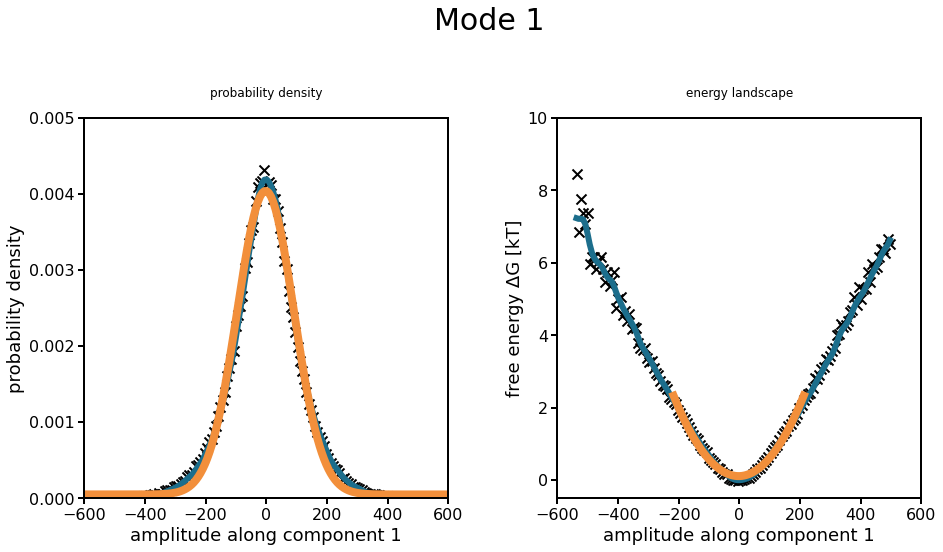

In [31]:
show_1d_energy(mode=0, setminimumtozero = True, energy_percentile_cut = 0.02, energy_gauss_percentile_cut = 3, 
               saveaspdf = True, show_legend = False, energy_fit = 'quadratic')

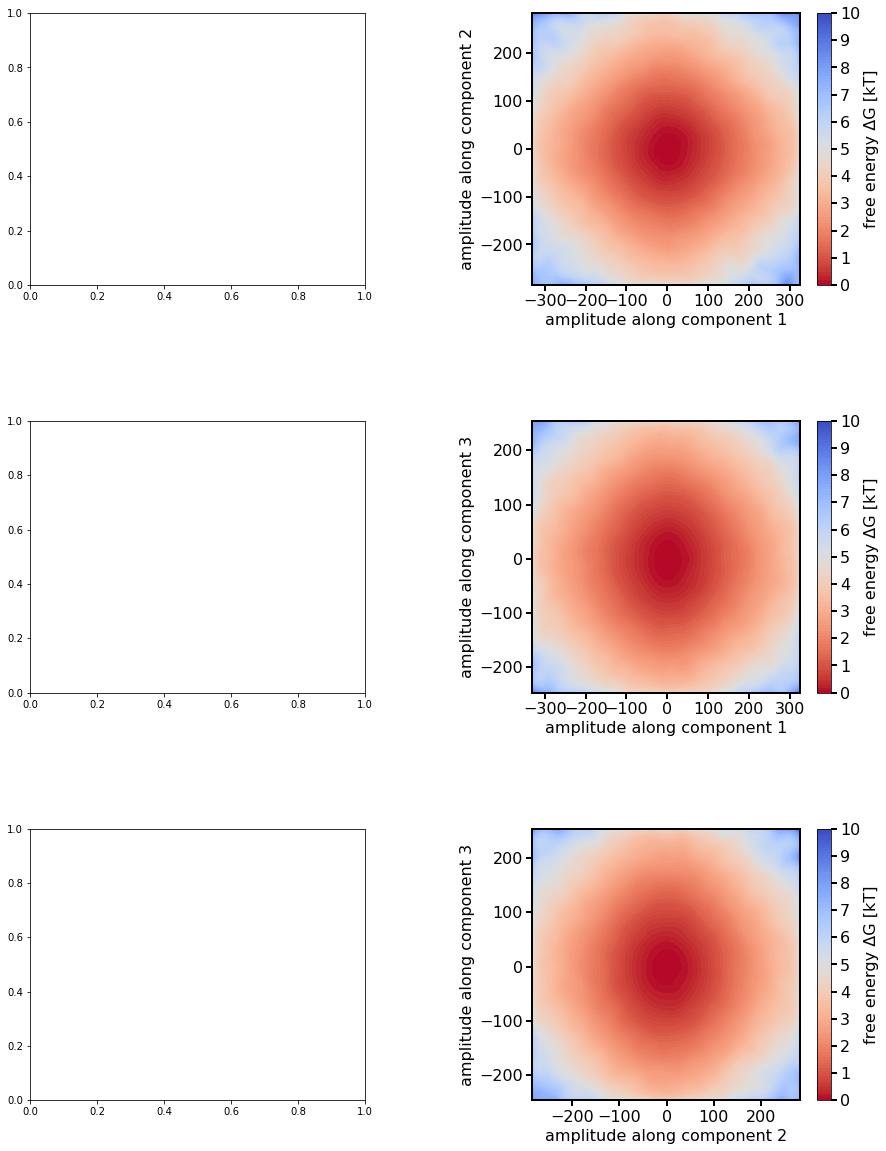

In [36]:
show_2d_energy(energy_percentile_cut = 0.5, setminimumtozero = True, saveaspdf = True)